This notebook demonstrates how to download Sentinel-2 data for a region of interest using the Sentinel API, then proceeding to mask out + save the raster for the regions of interest. 



In [ ]:
from sentinelsat import SentinelAPI, make_path_filter # for downloading data
import geopandas as gpd # for reading shapefiles
import folium  # library to create interactive maps
from shapely.geometry import MultiPolygon, Polygon
import os 
import rasterio as rio
from rasterio.mask import mask
import zipfile
import rasterio
import json
import shutil
from skimage.metrics import structural_similarity
import cv2
import numpy as np
# read credentials.json
with open('credentials.json') as f:
    credentials = json.load(f)

user = credentials['SENTINEL_USER']
password = credentials['SENTINEL_PASSWORD']
api = SentinelAPI(user, password, 'https://scihub.copernicus.eu/dhus')
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# load the shapefile for the region I want to view. (Created using geojson.io)
nyc_geo = gpd.read_file('data/layers/POLYGON.shp')

In [1]:
m = folium.Map([40.730610, -73.935242], zoom_start=10) # New York City

folium.GeoJson(nyc_geo).add_to(m)
# visualize the map
m

NameError: name 'folium' is not defined

In [5]:
# query sentinel api for this region
footprint = None
for i in nyc_geo['geometry']:
    footprint = i

    products = api.query(footprint,
                     date = ('20200101', '20220905'),
                     platformname = 'Sentinel-2',
                     processinglevel = 'Level-2A',
                     cloudcoverpercentage = (0,10)
                    )
    
products_gdf = api.to_geodataframe(products)
products_gdf['is_online'] = [api.is_online(product_id) for product_id in products_gdf.index]
products_gdf = products_gdf[products_gdf['is_online']]
products_gdf.sort_values('orbitnumber',ascending=True,inplace=True)
products_gdf.shape    

In [11]:
earliest_artifact = api.download(products_gdf.index[0])


In [12]:
latest_artifact = api.download(products_gdf.index[-1])

In [14]:
# unzip and remove compressed
try:
    with zipfile.ZipFile(latest_artifact['path']) as z:
        z.extractall()
        print("Extracted all")
        os.remove(latest_artifact['path'])
except:
    print("Invalid file")

try:
    with zipfile.ZipFile(earliest_artifact['path']) as z:
        z.extractall()
        print("Extracted all")
        os.remove(earliest_artifact['path'])
except:
    print("Invalid file")    

Extracted all


In [19]:
earliest_img_dir = earliest_artifact['path'].replace('.zip','.SAFE')
latest_img_dir = latest_artifact['path'].replace('.zip','.SAFE')

In [26]:
def get_bands(imagery_folders):

    l2a_folder = os.listdir(f'{imagery_folders}/GRANULE')[0]
    r10_path = f"{imagery_folders}/GRANULE/{l2a_folder}/IMG_DATA/R10m"
    for band in os.listdir(r10_path):
        # extract bands 2,3, and 4 from r10:
        if 'B02' in band:
            b2 = rio.open(f"{r10_path}/{band}")
        elif 'B03' in band:
            b3 = rio.open(f"{r10_path}/{band}")
        elif 'B04' in band:
            b4 = rio.open(f"{r10_path}/{band}")

    return b2, b3, b4

In [30]:
# save raster for earlier image, delete un-used files.
b2, b3, b4 = get_bands(earliest_img_dir)


with rio.open('RGB.tiff','w',driver='Gtiff', width=b4.width, height=b4.height, 
        count=3,crs=b4.crs,transform=b4.transform, dtype=b4.dtypes[0]) as rgb:
        rgb.write(b2.read(1),1) 
        rgb.write(b3.read(1),2) 
        rgb.write(b4.read(1),3) 
        rgb.close()

with rio.open("RGB.tiff") as src:
        out_meta = src.meta.copy()
        nyc_geo_projected = nyc_geo.to_crs(out_meta['crs'].data)
        out_image, out_transform = mask(src, nyc_geo_projected.geometry,crop=True) #TODO: note that projected has to be in the geo from out_meta. 
        out_meta = src.meta.copy()
        out_meta.update({"driver": "GTiff",
                        "height": out_image.shape[1],
                        "width": out_image.shape[2],
                        "transform": out_transform})

with rasterio.open(f"{earliest_artifact['title']}.tiff", "w", **out_meta) as dest:
        dest.write(out_image)


os.remove("RGB.tiff")
shutil.rmtree(earliest_img_dir)

# save raster for later image, delete un-used files.

b2, b3, b4 = get_bands(latest_img_dir)


with rio.open('RGB.tiff','w',driver='Gtiff', width=b4.width, height=b4.height, 
        count=3,crs=b4.crs,transform=b4.transform, dtype=b4.dtypes[0]) as rgb:
        rgb.write(b2.read(1),1) 
        rgb.write(b3.read(1),2) 
        rgb.write(b4.read(1),3) 
        rgb.close()

with rio.open("RGB.tiff") as src:
        out_meta = src.meta.copy()
        nyc_geo_projected = nyc_geo.to_crs(out_meta['crs'].data)
        out_image, out_transform = mask(src, nyc_geo_projected.geometry,crop=True) #TODO: note that projected has to be in the geo from out_meta. 
        out_meta = src.meta.copy()
        out_meta.update({"driver": "GTiff",
                        "height": out_image.shape[1],
                        "width": out_image.shape[2],
                        "transform": out_transform})

with rasterio.open(f"{latest_artifact['title']}.tiff", "w", **out_meta) as dest:
        dest.write(out_image)


os.remove("RGB.tiff")
shutil.rmtree(latest_img_dir)


/Users/noahkasmanoff/anaconda3/envs/nasaeo/lib/python3.9/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


# Quick Analysis of Region

In [43]:
earliest_raster = rio.open('S2B_MSIL2A_20200505T154809_N0214_R054_T18TWL_20200505T194233.tiff').read()
latest_raster = rio.open('S2A_MSIL2A_20220825T155151_N0400_R011_T18TWL_20220825T220800.tiff').read()

In [52]:
earliest_raster_mean = earliest_raster.mean(axis=0)
latest_raster_mean = latest_raster.mean(axis=0)

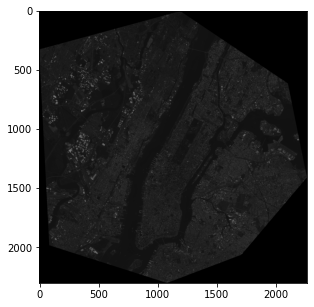

In [56]:
plt.figure(figsize=(5,5))
plt.imshow(latest_raster_mean,cmap='gray')